In [1]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sb
from sklearn.pipeline import Pipeline
from tabulate import tabulate
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv(
        filepath_or_buffer = '/content/drive/My Drive/costsensitiveregression.csv',
        sep = ',',
        header = 'infer')

data_head = df.head()
print(tabulate(data_head, headers='keys'))

      NotCount    YesCount    ATPM    PFD    PFG    SFD    SFG        WP    WS    AH    AN    Status    FNC
--  ----------  ----------  ------  -----  -----  -----  -----  --------  ----  ----  ----  --------  -----
 0           2          21       0  0          0      0      0  0            0     0     0         0      0
 1          23           0       0  0.044      0      0      0  0.306179     0     0     0         1      0
 2           1          22       0  0          0      0      0  0            0     0     0         0      0
 3           5          18       0  0          0      0      0  0            0     0     0         1      0
 4           1          22       0  0          0      0      0  0            0     0     0         0      0


In [3]:
# Gaining insights into the data for further processing

# Counting the occurrence of duplicate rows
print('Count of Duplicate Rows:')
duplicate_counts = df.duplicated().sum()
print(duplicate_counts)
print('\n' + '-' * 100 + '\n')

# Counting the occurrence of NaN values in each column
print('Count of NaN Values:')
print(df.isnull().sum())
print('\n' + '-' * 100 + '\n')

# Calculating the size of the dataset
num_data_points, num_features = df.shape
print(f'The dataset contains {num_data_points} data points and {num_features} features.')
print('\n' + '-' * 100 + '\n')

# Computing statistical summaries for numerical columns
print('Statistical Summary of Numerical Columns:')
print(df.select_dtypes(include='number').describe())
print('\n' + '-' * 100 + '\n')

# Summarizing the data type information
print('Summary of Data Type Information')
print(df.select_dtypes(include='number').info())
print('\n' + '-' * 100 + '\n')

Count of Duplicate Rows:
21621

----------------------------------------------------------------------------------------------------

Count of NaN Values:
NotCount    0
YesCount    0
ATPM        0
PFD         0
PFG         0
SFD         0
SFG         0
WP          0
WS          0
AH          0
AN          0
Status      0
FNC         0
dtype: int64

----------------------------------------------------------------------------------------------------

The dataset contains 147636 data points and 13 features.

----------------------------------------------------------------------------------------------------

Statistical Summary of Numerical Columns:
            NotCount       YesCount           ATPM            PFD  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        7.722107      15.220908       0.253245       0.027062   
std         7.574278       7.596921       0.366280       0.335509   
min         0.000000       0.000000       0.000000       0.000000   


<Figure size 600x400 with 0 Axes>

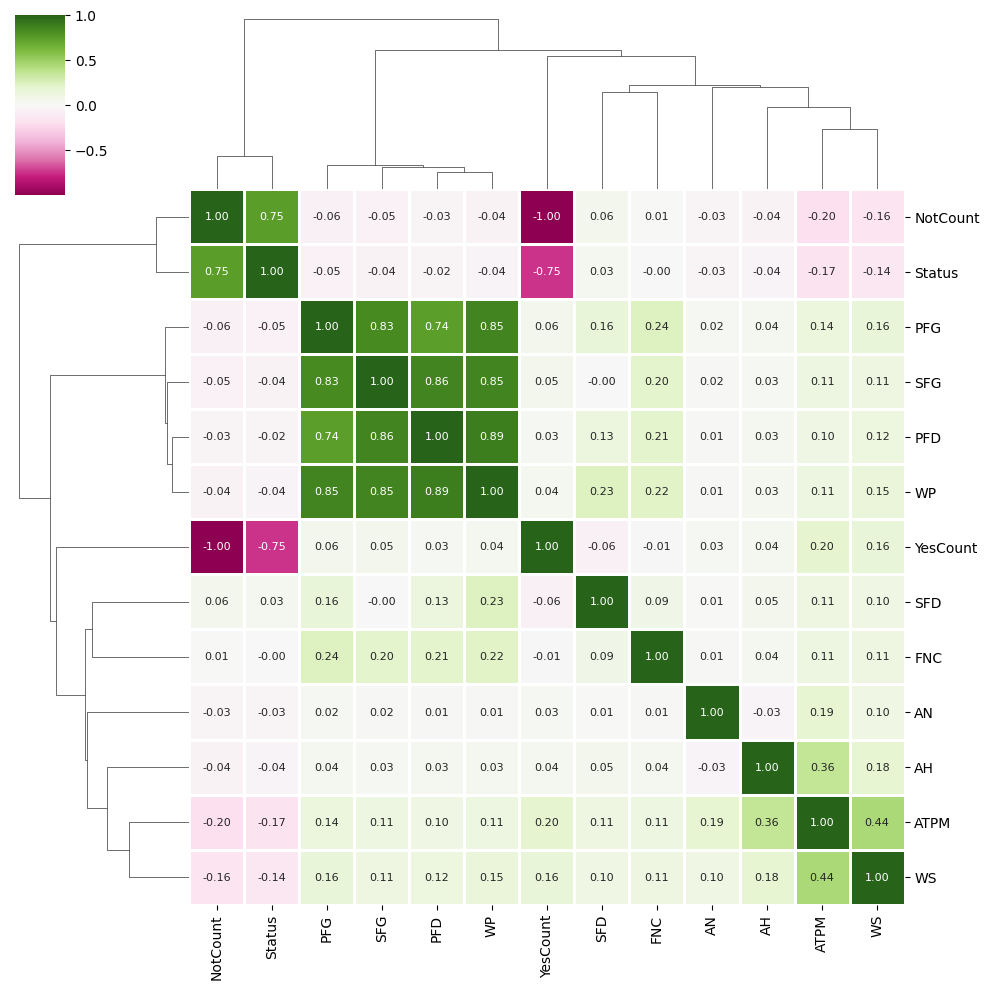

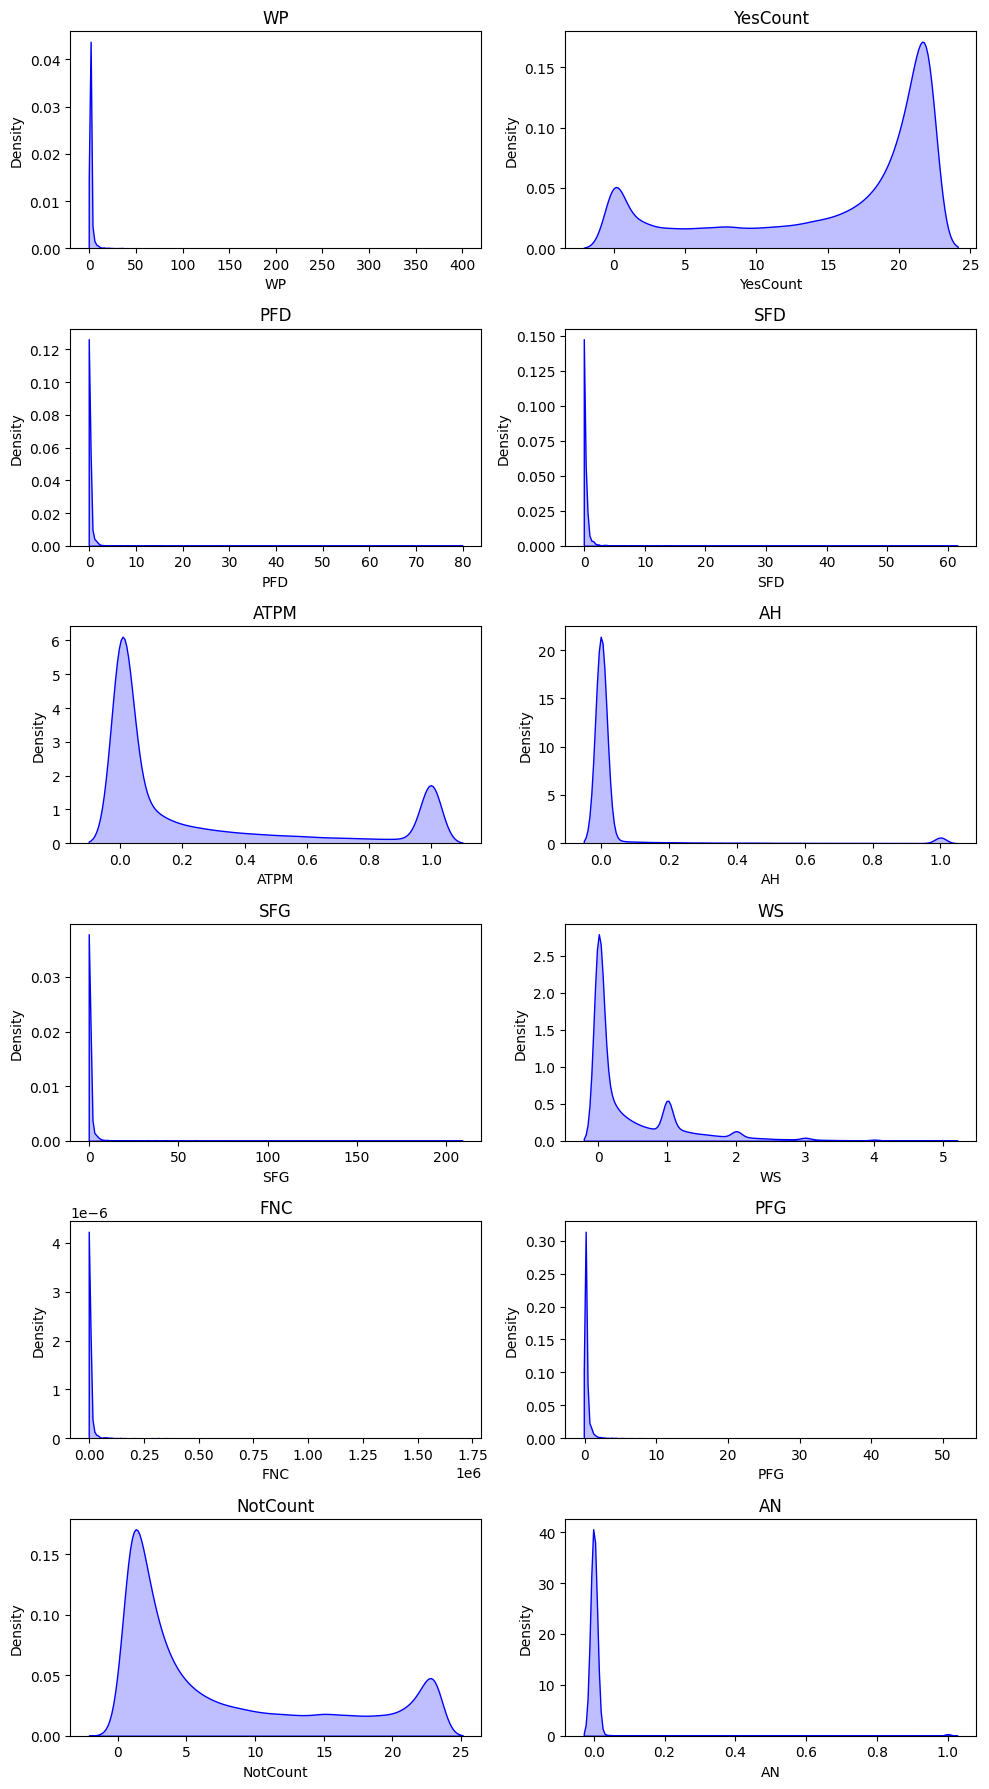

In [4]:
plt.figure(figsize=(6, 4))

# Display the correlation matrix between various features
sb.clustermap(
    data=df.corr('pearson'),
    annot_kws={'size': 8},
    annot=True,
    cmap='PiYG',
    linewidths=2,
    fmt='.2f'
)
plt.show()

# Examine the KDE plots for all features
num_columns = 2  # Number of columns in the subplot grid
unique_features = set(df.drop(['Status'], axis=1).columns)  # Set of unique features excluding 'Status' column
numofrows = (len(unique_features) + 1) // 2  # Number of rows needed to accommodate all features

# Create subplots with the specified number of rows and columns
f, axes = plt.subplots(numofrows, num_columns, figsize=(10, numofrows * 3))

# Iterate over each unique feature and its corresponding subplot axis
for i, (feature, axis) in enumerate(zip(unique_features, axes.flatten())):
    # Plot KDE (Kernel Density Estimation) plot for the feature on the current axis
    sb.kdeplot(df[feature], ax=axis, shade=True, color='blue')
    axis.set_title(feature)  # Set title of the subplot to the feature name

# Remove any extra subplots that are not needed
for i in range(len(unique_features), len(axes.flatten())):
    f.delaxes(axes.flatten()[i])

plt.tight_layout()  # Adjust subplot layout for better presentation
plt.show()  # Display the plot

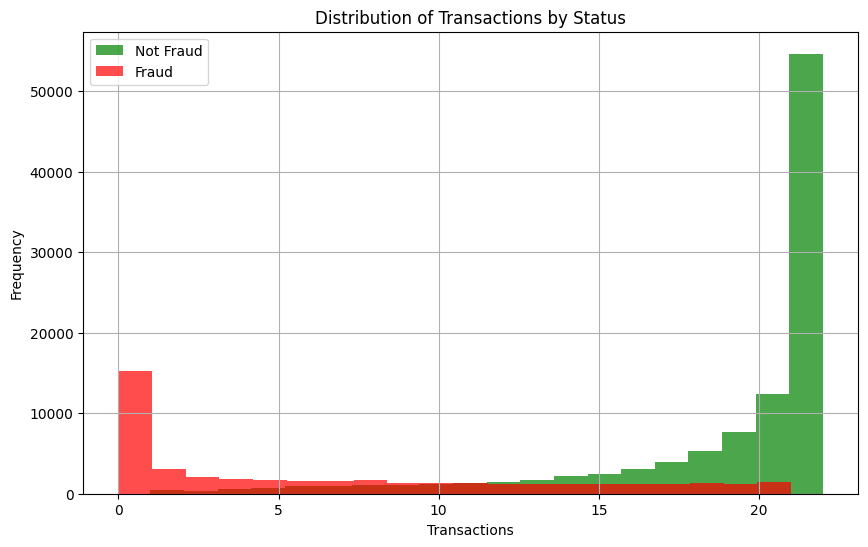

In [45]:
# Filter data for filed on time and status
Not_fraud = df['YesCount'][(df['Status'] == 0) & (df['YesCount'].notnull())]
fraud = df['YesCount'][(df['Status'] == 1) & (df['YesCount'].notnull())]

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(Not_fraud, bins=20, color='green', alpha=0.7, label='Not Fraud')
plt.hist(fraud, bins=20, color='red', alpha=0.7, label='Fraud')
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions by Status')
plt.legend(['Not Fraud', 'Fraud'])
plt.grid(True)
plt.show()


In [6]:
# Define a function to preprocess the data for model implementation
def process_data_for_model(df):
    # Remove duplicate rows
    df = df.drop_duplicates()
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    return df

In [7]:
# Create a cost-sensitive cost-matrix incorporating True Positives, False Positives, True Negatives, and False Negatives for the entire dataset
custom_cost_matrix = np.zeros((len(df), 4))

# Assign a cost of 0 for True Negatives (TN)
custom_cost_matrix[:, 2] = 0

# Assign a cost of 6 for False Positives (FP)
custom_cost_matrix[:, 1] = 6

# Incorporate the false negative cost from the 'FNC' column of the dataset into the cost matrix
custom_cost_matrix[:, 3] = df['FNC']

# Assign a cost of 6 for True Positives (TP)
custom_cost_matrix[:, 0] = 6

In [8]:
# Separate features and target labels
custom_target_labels = df['Status']
custom_feature_data = df.drop(['Status', 'FNC'], axis=1)

# Split the data into training and testing sets
training_x, testing_x, training_y, testing_y = train_test_split(
    custom_feature_data, custom_target_labels, test_size=0.2, random_state=42
)

In [9]:
# Set parameters for the training algorithm
custom_parameters = {
    "generations": 100,
    "rate": 0.01,
    "size": 50
}
# Unpack parameters for convenience
custom_num_generations = custom_parameters["generations"]
custom_mutation_rate = custom_parameters["rate"]
custom_population_size = custom_parameters["size"]

In [10]:
# Generate the cost-sensitive cost-matrix with True Positives, False Positives, True Negatives, and False Negatives for X_training
cost_matrix_X_training_custom = custom_cost_matrix[training_x.index]

# Generate the cost-sensitive cost-matrix with True Positives, False Positives, True Negatives, and False Negatives for X_testing
cost_matrix_X_testing_custom = custom_cost_matrix[testing_x.index]

In [11]:
# Define a pipeline for Min-Max Scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

data_scaler_custom = Pipeline([
    ('scaler', MinMaxScaler())
])

# Apply Min-Max Scaling to the DataFrame
training_x = data_scaler_custom.fit_transform(training_x)
testing_x = data_scaler_custom.transform(testing_x)

In [12]:
class GACustom:

    def tanh(self, a):
        return np.tanh(a)

    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))

    def relu(self, a):
        return np.maximum(0, a)

    def custom_function_cost_(self, theta, X, y, cost_matrix):
        # Step 1: Calculate predictions using logistic regression function
        predictions_custom = self.function_for_logistic_regression(theta, X)

        # Step 2: Calculate loss using logistic loss function
        loss_custom = self.functionforlogisticloss(y, predictions_custom, cost_matrix)
        self.loss.append(loss_custom)

        # Step 3: Return the computed loss
        return loss_custom

    def function_for_logistic_regression(self, theta, X, activation='sigmoid'):
        if activation == 'sigmoid':
            return self.sigmoid(np.dot(X, theta))
        elif activation == 'tanh':
            return self.tanh(np.dot(X, theta))
        elif activation == 'relu':
            return self.relu(np.dot(X, theta))
        else:
            raise ValueError("Unsupported activation function. Choose from 'sigmoid', 'tanh', or 'relu'.")

    def functionforlogisticloss(self, true_y, pred_y, matrixofcost):
        log_loss_positive = true_y * np.log(pred_y)
        log_loss_negative = (1 - true_y) * np.log(1 - pred_y)
        total_loss = log_loss_positive + log_loss_negative
        mean_loss = -np.mean(total_loss)
        return mean_loss

    def __init__(self, rateofmutation=0.01, numberofgenerations=1000, sizeofpopulation=100):
        self.custom_mutation_rate = rateofmutation
        self.custom_num_generations = numberofgenerations
        self.population_size_custom = sizeofpopulation
        self.loss=[]
        self.custom_weights = None


    def cstm_predict(self, X_custom):
        X_custom = np.hstack((np.ones((X_custom.shape[0], 1)), X_custom))
        predictions_custom = self.function_for_logistic_regression(self.weights_custom, X_custom)
        return (predictions_custom >= 0.9).astype(int)

    def custom_fit(self, matrix_for_cost, y_custom, X_custom):
        # Create a column vector of ones with the same number of rows as X_custom
        bias_column = np.ones((X_custom.shape[0], 1))

        # Concatenate the bias_column and training_x horizontally
        X_custom = np.concatenate((bias_column, training_x), axis=1)

        # Get the shape of X_custom, which is a tuple (number of rows, number of columns)
        X_custom_shape = X_custom.shape

        # Extract the number of columns (features) from the shape tuple
        custom_number_features = X_custom_shape[1]

        # Generate a random matrix representing the population parameters
        # The matrix has dimensions (population_size_custom, custom_number_features)
        # Each element is a random number between 0 and 1
        custom_population = np.random.random((self.population_size_custom, custom_number_features))

        for generation_custom in range(self.custom_num_generations):
            fitness_scores_custom = np.array([self.custom_function_cost_(theta, X_custom, y_custom, matrix_for_cost) for theta in custom_population])

            selected_indices_custom = np.random.choice(self.population_size_custom, size=self.population_size_custom, replace=True, p=fitness_scores_custom / np.sum(fitness_scores_custom))
            selected_individuals_custom = custom_population[selected_indices_custom]

            parent_indices_custom = np.random.choice(self.population_size_custom, size=(self.population_size_custom, 2), replace=True)
            crossover_points_custom = np.random.randint(1, custom_number_features, size=self.population_size_custom)
            offspring_custom = np.empty((self.population_size_custom, custom_number_features))

            for i in range(self.population_size_custom):
                parent1_custom, parent2_custom = selected_individuals_custom[parent_indices_custom[i]]
                crossover_point_custom = crossover_points_custom[i]
                child_custom = np.concatenate((parent1_custom[:crossover_point_custom], parent2_custom[crossover_point_custom:]))
                offspring_custom[i] = child_custom

            mutation_indices_custom = np.random.randint(0, custom_number_features, size=(self.population_size_custom, custom_number_features))
            mutation_mask = np.random.rand(self.population_size_custom, custom_number_features) < self.custom_mutation_rate
            offspring_custom += np.random.normal(0, 0.1, size=(self.population_size_custom, custom_number_features)) * mutation_mask

            custom_population = offspring_custom


        costs_custom = np.array([self.custom_function_cost_(theta, X_custom, y_custom, matrix_for_cost) for theta in custom_population])
        best_individual_custom = custom_population[np.argmin(costs_custom)]
        self.weights_custom = np.array(best_individual_custom)



In [13]:
# Initialize the cost matrix for training data
num_training_samples = training_x.shape[0]
num_classes = 4
cost_matrix_train = np.ones((num_training_samples, num_classes))
num_testing_samples = testing_x.shape[0]
cost_matrix_test = np.ones((testing_x.shape[0], num_classes))

# Instantiate the genetic algorithm with default parameters
mutation_rate = custom_mutation_rate
num_generations = custom_num_generations
population_size = custom_population_size
genetic_alg = GACustom(mutation_rate, num_generations, population_size)


# Fit the genetic algorithm on the training data
cost_matrix = cost_matrix_train
labels = training_y
features = training_x

genetic_alg.custom_fit(cost_matrix, labels, features)

# Predict on the test data using the trained model
testing_features = testing_x
normal_y_pred = genetic_alg.cstm_predict(testing_features)

# Calculate the accuracy score
accuracy = accuracy_score(testing_y, normal_y_pred)
accuracy

0.6201910051476565

In [14]:
class GeneticAlgorithmBahnsen(GACustom):

    def logistic_loss(self, y_true, y_pred, cost_matrix):
      TP, FP, TN, FN = custom_cost_matrix.T
      # Calculate true positive terms
      TP_terms = y_true * (y_pred * TP + (1 - y_pred) * FN)

      # Calculate false positive terms
      FP_terms = (1 - y_true) * (y_pred * FP + (1 - y_pred) * TN)

      #Combine TP and FP terms and calculate mean
      val = np.mean(TP_terms + FP_terms)

      return val

    def __init__(self, numberofgenerations = 1000, rateofmutation = 0.01, sizeofpopulation = 100):
      self.custom_num_generations = numberofgenerations
      self.custom_mutation_rate = rateofmutation
      self.custom_population_size = sizeofpopulation
      super().__init__(rateofmutation, numberofgenerations, sizeofpopulation)


  # Instantiate the Genetic Algorithm
bah = GeneticAlgorithmBahnsen(custom_num_generations, custom_mutation_rate, custom_population_size)

  # Fit the model
bah.custom_fit(cost_matrix_X_training_custom, training_y, training_x)

  # Predict using the trained model
bah_y_pred = bah.cstm_predict(testing_x)

  # Calculate accuracy
accuracy = accuracy_score(testing_y, bah_y_pred)

  # Display accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6237469520455161


In [24]:
# Main Algorithm Starts here
class NikouGunnemann(GACustom):

    def __init__(self, numberofgenerations = 1000, rateofmutation = 0.01, sizeofpopulation = 100):
      self.custom_num_generations = numberofgenerations
      self.custom_mutation_rate = rateofmutation
      self.custom_population_size = sizeofpopulation
      super().__init__(rateofmutation, numberofgenerations, sizeofpopulation)

    def logistic_loss(self, y_true, y_pred, cost_matrix):

        # Variant A
        a = cost_matrix[:, 3]
        b = np.ones(cost_matrix.shape[0])

        val= -np.mean(a * y_true * np.log(y_pred ** b) + a * (1 - y_true) * np.log(1 - y_pred ** b)) * y_pred.shape[0]

        return val


gun = NikouGunnemann(custom_num_generations, custom_mutation_rate, custom_population_size)
gun.custom_fit(cost_matrix_X_training_custom, training_y, training_x)
gun_y_pred = gun.cstm_predict(testing_x)

  # Calculate accuracy
accuracy = accuracy_score(testing_y, gun_y_pred)

  # Display accuracy
print("Accuracy:", accuracy)


Accuracy: 0.6498238959631536


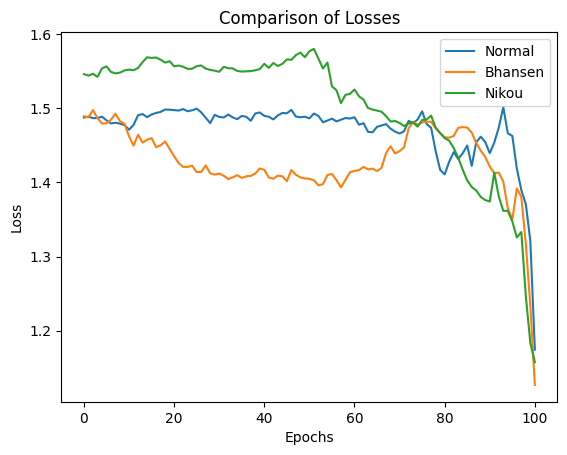

In [25]:
# Define a function to calculate the average at regular intervals
def average_at_regular_interval(arr, interval=10):
    return [sum(arr[i:i+interval])/interval for i in range(0, len(arr), interval)][::-1]

# Calculate average losses for each model at regular intervals
models = [genetic_alg, bah, gun]
avg_losses = [average_at_regular_interval(model.loss, 50) for model in models]
model_names = ['Normal', 'Bhansen', 'Nikou']

# Plot all losses on the same axes
for losses, name in zip(avg_losses, model_names):
    plt.plot(losses, label=name)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Losses')
plt.legend()  # Show legend with labels
plt.show()


In [26]:
from sklearn.metrics import classification_report

# Define the models and their predictions
models = ['Normal', 'Bhansen', 'Nikou']
predictions = [normal_y_pred, bah_y_pred, gun_y_pred]

# Loop over each model to print the classification report
for model, prediction in zip(models, predictions):
    # Print the classification report
    print(f'Classification Report for the {model}\n')
    print(classification_report(testing_y, prediction))


Classification Report for the Normal

              precision    recall  f1-score   support

           0       0.69      0.82      0.75     20707
           1       0.25      0.14      0.18      8821

    accuracy                           0.62     29528
   macro avg       0.47      0.48      0.47     29528
weighted avg       0.56      0.62      0.58     29528

Classification Report for the Bhansen

              precision    recall  f1-score   support

           0       0.68      0.87      0.76     20707
           1       0.13      0.05      0.07      8821

    accuracy                           0.62     29528
   macro avg       0.41      0.46      0.42     29528
weighted avg       0.52      0.62      0.56     29528

Classification Report for the Nikou

              precision    recall  f1-score   support

           0       0.69      0.92      0.79     20707
           1       0.05      0.01      0.02      8821

    accuracy                           0.65     29528
   macro avg  

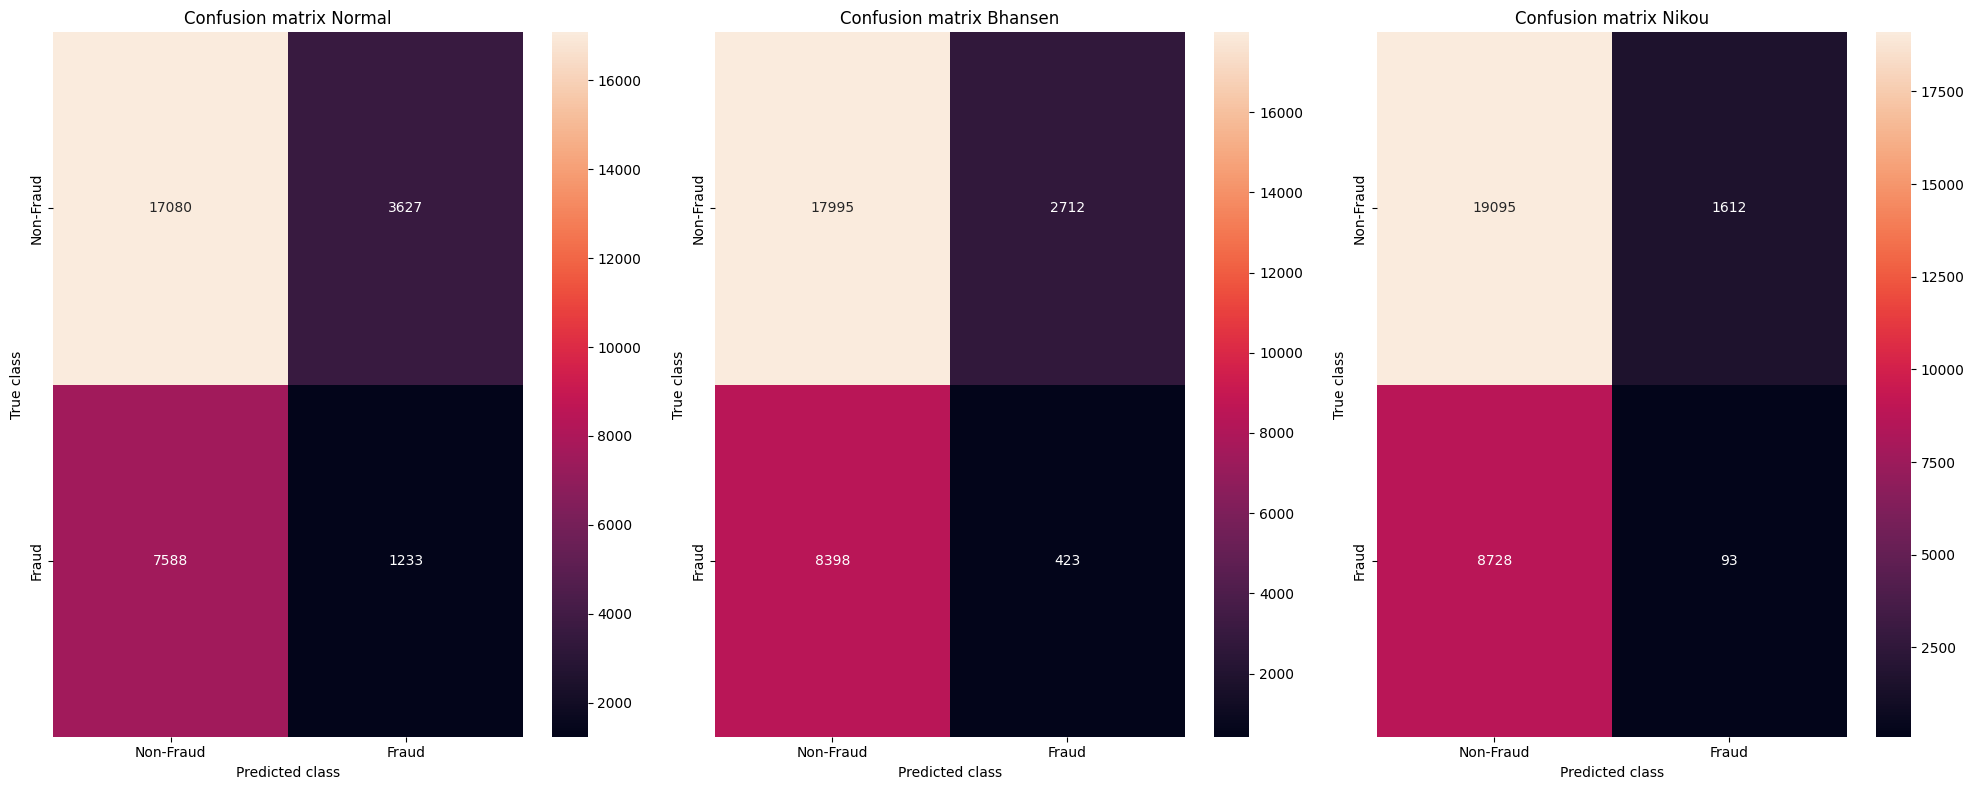

In [41]:
# Define the models and their predictions
models = ['Normal', 'Bhansen', 'Nikou']
predictions = [normal_y_pred, bah_y_pred, gun_y_pred]

# Set up the figure and axes
fig, axes = plt.subplots(1, len(models), figsize=(20, 8))

# Loop over each model to plot the confusion matrix
for i, (model, prediction) in enumerate(zip(models, predictions)):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(testing_y, prediction)

    # Plot the confusion matrix
    sb.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", ax=axes[i])

    # Set the title and labels
    axes[i].set_title(f'Confusion matrix {model}')
    axes[i].set_ylabel('True class')
    axes[i].set_xlabel('Predicted class')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [34]:
def cost_score(a, y_true, y_pred):
    return np.sum(a * (y_pred != y_true))

# Define the models and their predictions
models = ['Normal', 'Bhansen', 'Nikou']
predictions = [normal_y_pred, bah_y_pred, gun_y_pred]

# Define the cost matrices for each model
cost_matrices = [cost_matrix_test[:, 3], cost_matrix_X_testing_custom[:, 3], cost_matrix_X_testing_custom[:, 3]]

# Loop over each model to calculate and print the cost score
for model, prediction, cost_matrix in zip(models, predictions, cost_matrices):
    # Calculate the cost score
    cs = cost_score(cost_matrix, testing_y, prediction)

    # Print the cost score
    print(f'Cost Score for {model}')
    print(cs)


Cost Score for Normal
11215.0
Cost Score for Bhansen
10808479.936943999
Cost Score for Nikou
9445814.126348
